The goal of this project is to classify images of seedlings into 1 of 12 possible species. After some initial data exploration, I will perform some pre-processing using computer vision techniques in order to accelerate the training process. Finally, I will train a CNN model and generate a submission file containing predictions for the test set provided by Kaggle.

In [1]:
import pandas as pd
import numpy as np
import keras
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random
import pickle
from keras import models, layers, callbacks
import shutil
import cv2
from math import sqrt, floor
from prettytable import PrettyTable

First, lets have a look at the directory structure seen below. The three dots (...) indicate that there were too many files in the directory to list

In [2]:
def print_bold(text):
    print('\033[1m{}\033[0m'.format(text))

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        
        dir_name= '{}{}/'.format(indent, os.path.basename(root))
        if dir_name.strip().startswith('.'):
            continue
        
        print_bold('\n'+dir_name)
            
        subindent = ' ' * 4 * (level + 1)
        if level==0:
            for f in files:
                if f.startswith('.'):
                    continue
                print('{}{}'.format(subindent, f))
        else:
            #if len(files)>0:
            #   print('{}File Count: {}'.format(subindent, len(files)))
            for i, f in enumerate(files):
                print('{}{}'.format(subindent, f))
                if i==2:
                    print('{}{}'.format(subindent, '...'))
                    break

list_files(os.getcwd())


plant-seedlings-classification/
    Seedling_Classification.ipynb
    test.zip
    train.zip

    test/
        0021e90e4.png
        003d61042.png
        007b3da8b.png
        ...

    train/

        Black-grass/
            0183fdf68.png
            0260cffa8.png
            05eedce4d.png
            ...

        Charlock/
            022179d65.png
            04098447d.png
            04142acb9.png
            ...

        Cleavers/
            005b4a3e3.png
            00aa8d5a4.png
            01605ed73.png
            ...

        Common Chickweed/
            00b6eee9f.png
            00ba5f88a.png
            01eef6041.png
            ...

        Common wheat/
            012db0f43.png
            01a2ae45e.png
            096ec46ec.png
            ...

        Fat Hen/
            00268e97d.png
            008f1b92d.png
            009004da3.png
            ...

        Loose Silky-bent/
            0012f11c4.png
            01897adc9.png
            02b15993e.png
        

The parent folder of our training images indicates the class label. Lets have a look at the count of records for each class

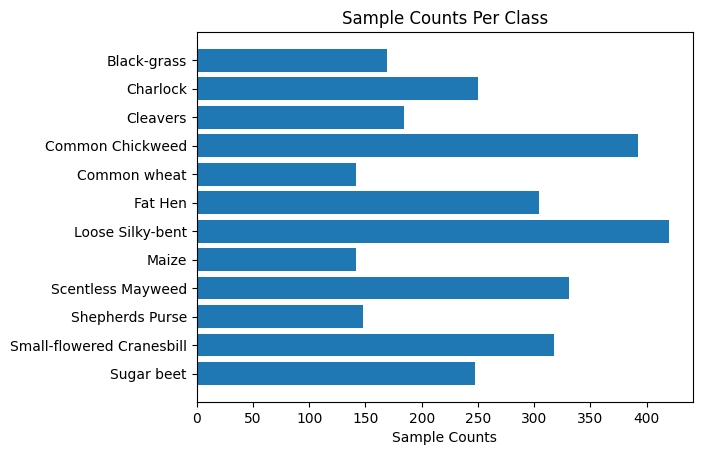

In [3]:
classes= []
sample_counts= []

for f in os.listdir('train'):
    train_class_path= os.path.join('train', f)
    if os.path.isdir(train_class_path):
        classes.append(f)
        sample_counts.append(len(os.listdir(train_class_path)))

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(classes))

ax.barh(y_pos, sample_counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sample Counts')
ax.set_title('Sample Counts Per Class')

plt.show()

As seen above, there is some class inbalance. I will account for this by defining class weights at the time of training. Lets have a look at a few random images from each class.

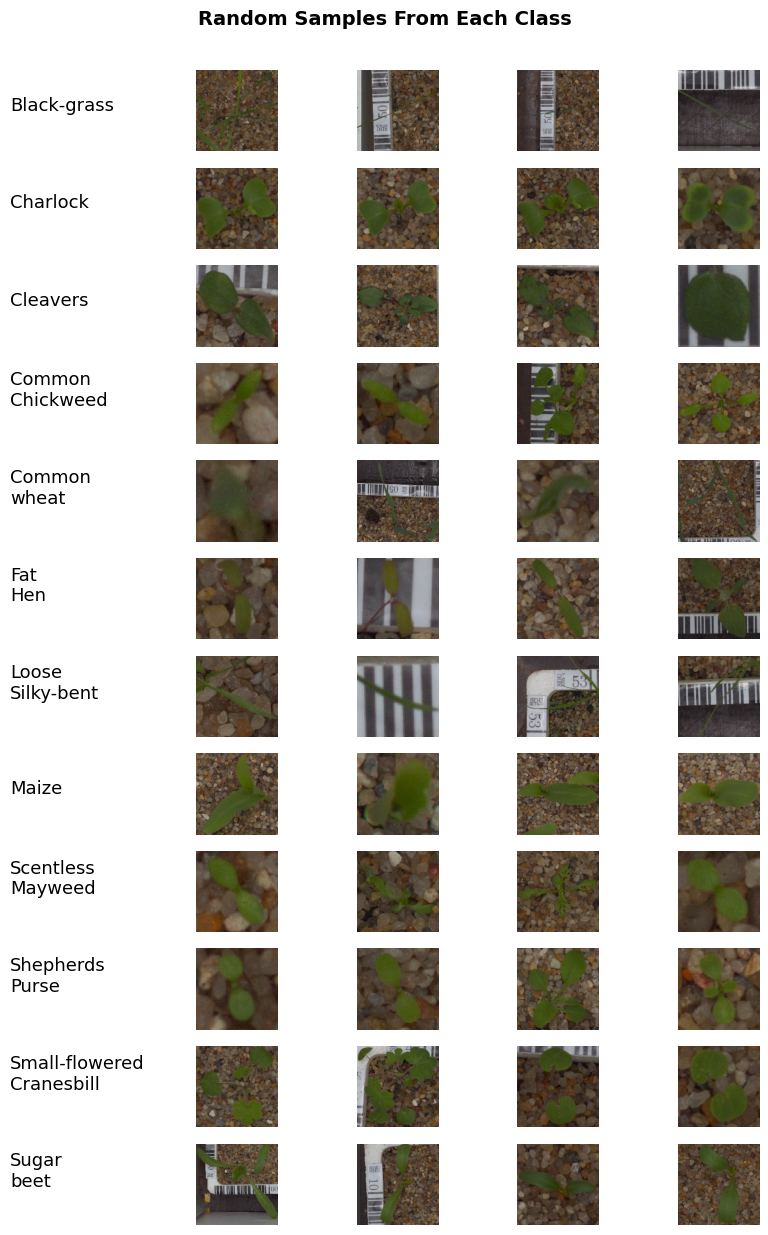

In [4]:
fig= plt.figure(figsize= (10, 15))
fig.suptitle('Random Samples From Each Class', fontsize=14, y=.92, horizontalalignment='center', weight='bold')

columns = 5
rows = 12
for i in range(12):
    sample_class= os.path.join('train',classes[i])
    for j in range(1,6):
        fig.add_subplot(rows, columns, i*5+j)
        plt.axis('off')
        if j==1:
            plt.text(0.0, 0.5,str(classes[i]).replace(' ','\n'), fontsize=13, wrap=True)
            continue
        random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
        #from keras.preprocessing.image
        img = image.load_img(random_image, target_size=(150, 150))
        img= image.img_to_array(img)
        img/=255.
        plt.imshow(img)
        
        

plt.show()


There are some important things to note here. We see that the resolution of these images can vary significantly. We also see that images for a particular specied seem to have been taken at various points of its life cycle. Luckily, all of the images share a roughly similar background which may allow for us to remove it from the image in order to accelerate training.

Before doing this, we must address the fact that there is no validation dataset yet. I will construct a validation set using 20% of the training set. In order to maintain the same distribution, I will randomly select 20% from each class.

In [5]:
#create validation set
def create_validation(validation_split=0.2):
    if os.path.isdir('validation'):
        print('Validation directory already created!')
        print('Process Terminated')
        return
    os.mkdir('validation')
    for f in os.listdir('train'):
        train_class_path= os.path.join('train', f)
        if os.path.isdir(train_class_path):
            validation_class_path= os.path.join('validation', f)
            os.mkdir(validation_class_path)
            files_to_move= int(0.2*len(os.listdir(train_class_path)))
            
            for i in range(files_to_move):
                random_image= os.path.join(train_class_path, random.choice(os.listdir(train_class_path)))
                shutil.move(random_image, validation_class_path)
    print('Validation set created successfully using {:.2%} of training data'.format(validation_split))
                

In [6]:
create_validation()

Validation directory already created!
Process Terminated


Now lets have a look at a bar chart showing counts for each class in our training and validation set.

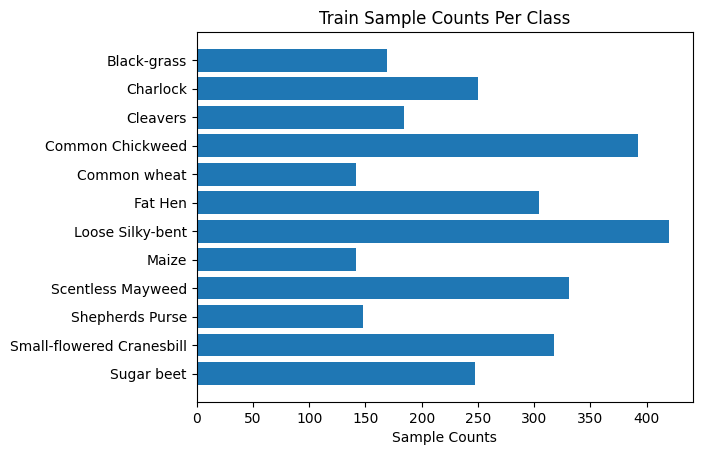

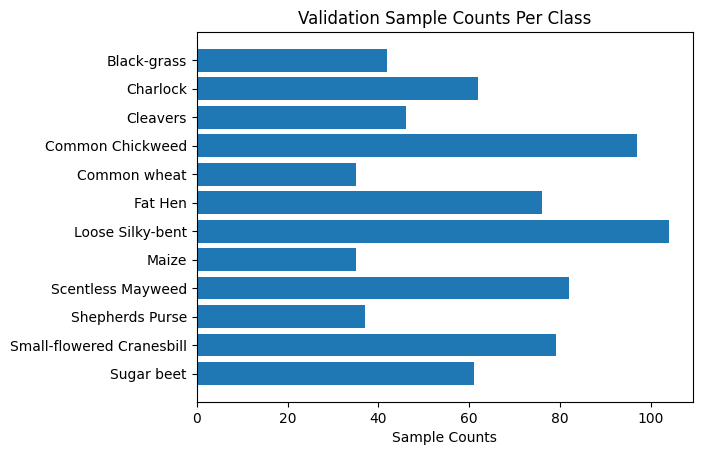

In [7]:
sample_counts= {}

for i, d in enumerate(['train', 'validation']):

    classes= []
    sample_counts[d]= []

    for f in os.listdir(d):
        train_class_path= os.path.join(d, f)
        if os.path.isdir(train_class_path):
            classes.append(f)
            sample_counts[d].append(len(os.listdir(train_class_path)))

    #fig, ax= plt.subplot(221+i)
    fig, ax = plt.subplots()

    # Example data
    y_pos = np.arange(len(classes))

    ax.barh(y_pos, sample_counts[d], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Sample Counts')
    ax.set_title('{} Sample Counts Per Class'.format(d.capitalize()))

plt.show()

The class with the fewest number of records in our validation set has just over 40 records. Although this is less than ideal, it should still be sufficient to get a decent measure of our model's accuracy.

Now I will attempt to remove the background from the images to see if can find a method which generalizes well across all images, then this can be used to accelerate training by isolating the important part of our data. The strategy will be to find upper and lower bounds within a color space which will only contain the green part of the plants. We will then turn the rest of the background black. In order to find the best values for these upper and lower bounds, I grab random pixels from random training images from each of my 12 classes. I will then take this random collection of pixels and plot it in color space i hopes that I can find upper and lower bounds which cleanly seperate the green part of the plants. 

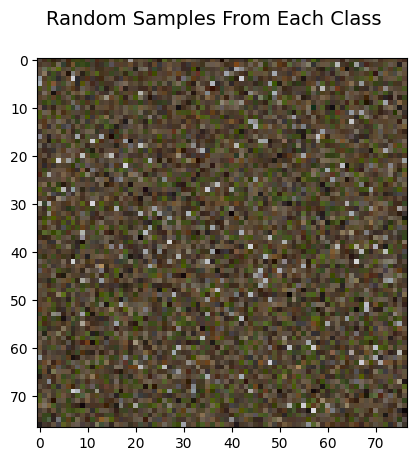

In [8]:
def pull_random_pixels(samples_per_class, pixels_per_sample):
    total_pixels= 12*samples_per_class*pixels_per_sample
    random_pixels= np.zeros((total_pixels, 3), dtype=np.uint8)
    for i in range(12):
        sample_class= os.path.join('train',classes[i])
        for j in range(samples_per_class):
            
            random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
            img= cv2.imread(random_image)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img=np.reshape(img, (img.shape[0]*img.shape[1], 3))
            new_pixels= img[np.random.randint(0, img.shape[0], pixels_per_sample)]
            
            start_index=pixels_per_sample*(i*samples_per_class+j)
            random_pixels[start_index:start_index+pixels_per_sample,:]= new_pixels

    h= floor(sqrt(total_pixels))
    w= total_pixels//h
    
    random_pixels= random_pixels[np.random.choice(total_pixels, h*w, replace=False)]
    random_pixels= np.reshape(random_pixels, (h, w, 3))
    return random_pixels
    
random_pixels= pull_random_pixels(10, 50)

plt.figure()
plt.suptitle('Random Samples From Each Class', fontsize=14, horizontalalignment='center')
plt.imshow(random_pixels)
plt.show()


The image above is a random sampling of 50 pixels from each of 10 training images from each of 12 classes. I will now plot these pixels in color space (RGB).

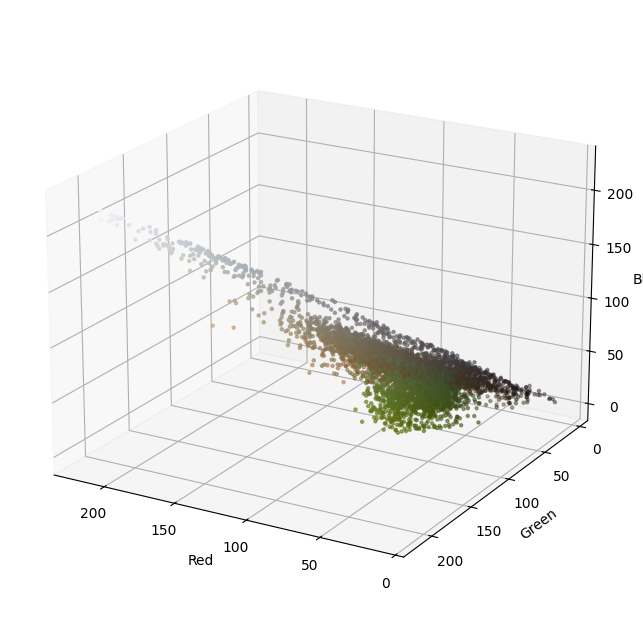

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

r, g, b = cv2.split(random_pixels)
fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.view_init(20, 120)

pixel_colors = random_pixels.reshape((np.shape(random_pixels)[0]*np.shape(random_pixels)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()


axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

From an initial view, it looks like the green regions may be seperable from the rest, but simply coosing bounds of RGB values will not work due to the shape of the distribution. Before resorting to more sophisticated methods to isolate these pixels, lets try a differe color space basis (HSV).

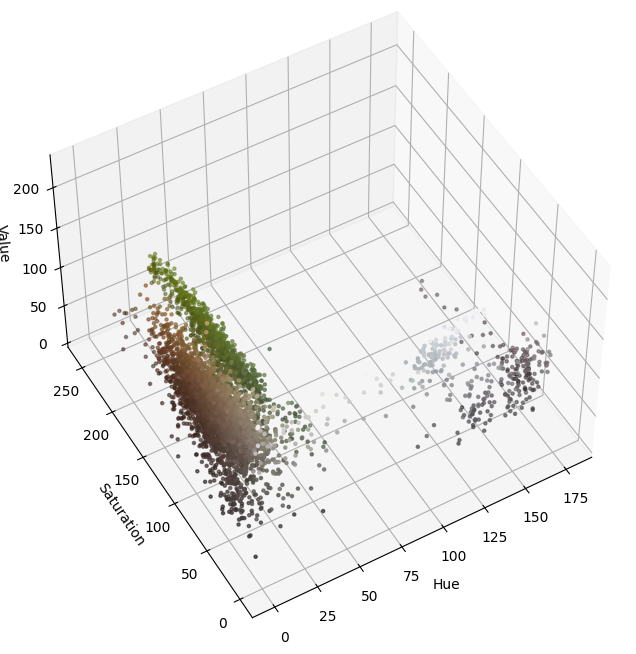

In [10]:
hsv_img = cv2.cvtColor(np.uint8(random_pixels), cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_img)
fig = plt.figure(figsize=(8,8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.view_init(50, 240)



axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In HSV space, it looks like our clusters are more neatly seperable by choosing upper and lower bounds of HSV values. We can also clearly see that the green cluster comes from the plants and the brown, white, and grey clusters must come from the dirt, rocks, and other things in the background. It looks like there is little variance along the V (value) axis, so lets plot this in 2 dimensions (H & S).

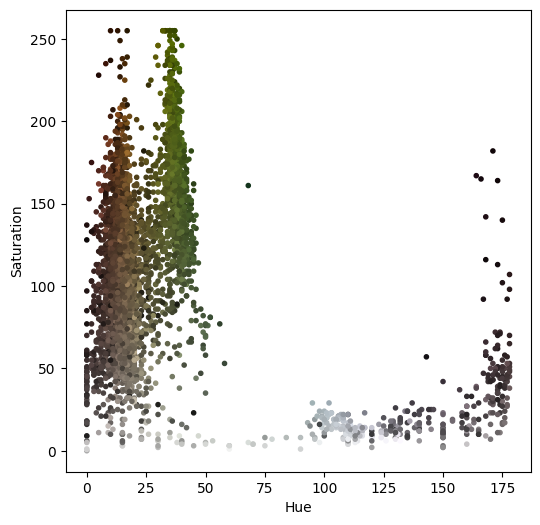

In [11]:
hsv_img = cv2.cvtColor(np.uint8(random_pixels), cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_img)
fig = plt.figure(figsize=(6,6))
axis = fig.add_subplot(1, 1, 1)

axis.scatter(h.flatten(), s.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
plt.show()

From here, we can point to an upper and lower bound. I will isolate pixels with Hue values ranging from 24 to 55 and Saturation values ranging from 50 to 255.

I will grab a random image from each class and use the cv2 library to map the pixels in HSV space and black out the background using the bounds I've identified previously. I will display the original and transformed images next to eachother.

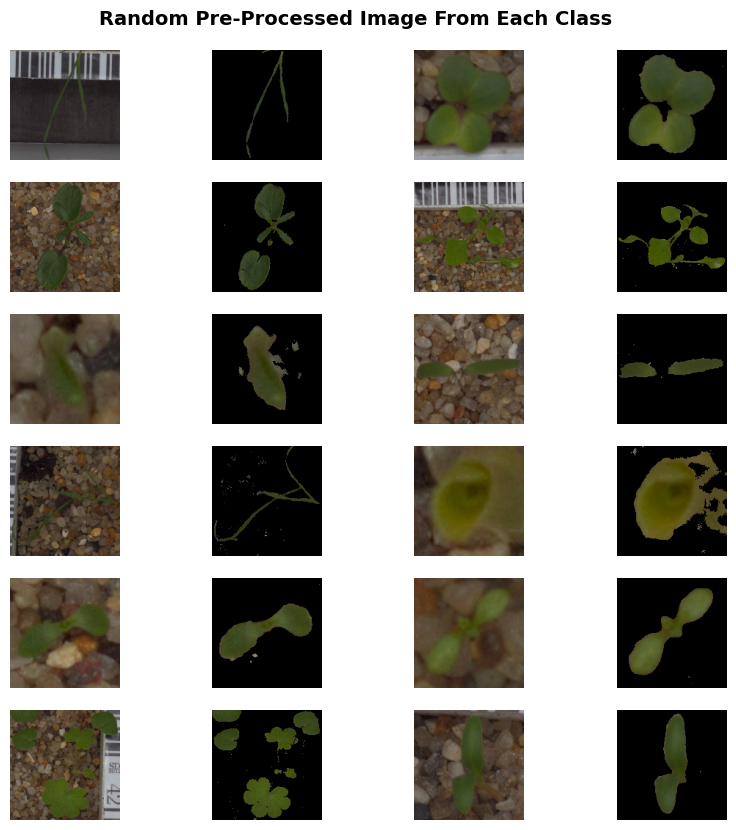

In [12]:
lower_bound= (24, 50, 0)
upper_bound= (55, 255, 255)

fig= plt.figure(figsize=(10, 10))
fig.suptitle('Random Pre-Processed Image From Each Class', fontsize=14, y=.92, horizontalalignment='center', weight='bold')

for i in range(12):
    sample_class=os.path.join('train',classes[i])
    random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, (150, 150))
    
    hsv_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    result = cv2.bitwise_and(img, img, mask=mask)

    fig.add_subplot(6, 4, i*2+1)
    plt.imshow(img)
    plt.axis('off')    

    fig.add_subplot(6, 4, i*2+2)
    plt.imshow(result)
    plt.axis('off')
    
plt.show()

This approach seems to have worked well. I will use this in my model. Its important to note that this should <em>not</em> be done if we expect the background to vary in real data. For example, if we were developing an ML application for these specific gardeners, then this pre-processing should be fine since we expect real life data to have a background consistent with what we see here. If we were to generalize this application to seedling images with different backgrounds, using different cameras, etc. then our pre-processing technique may cause issues.

I will create a function to make the above transformation compatible with the ImageDataGenerator object from Keras, which I will be using in our model. 

In [13]:
def color_segment_function(img_array):
    img_array= np.rint(img_array)
    img_array= img_array.astype('uint8')
    hsv_img= cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, (24, 50, 0), (55, 255, 255))
    result = cv2.bitwise_and(img_array, img_array, mask=mask)
    result= result.astype('float64')
    return result

I will take advantage of data augmentation during training. Our training generator will apply random flips and rotations to our images in addition to the background removal function I've defined above. I will also define a validation and testing generator. The advantage of using generators is that there we can do our training and validation in batches while also avoiding the need to load all of our data into memory at once. This is especially important when working with large datasets which may be too large to even store locally.

In [14]:
#image function from keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the train and test ImageDataGenerators
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.0,
      height_shift_range=0.0,
      shear_range=0.0,
      zoom_range=0.0,
      horizontal_flip=True,
      vertical_flip=True,
      preprocessing_function=color_segment_function,  # Custom preprocessing function
      fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
      rescale=1./255,
      preprocessing_function=color_segment_function  # Custom preprocessing function
)


In [15]:
train_generator = train_datagen.flow_from_directory(
  'train',
  target_size=(150, 150),
  batch_size=20,
  class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(150,150),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 3047 images belonging to 12 classes.
Found 756 images belonging to 12 classes.
Found 0 images belonging to 0 classes.


I will now construct a set of class weights to be provided during training in order to account for the class imbalance I've noted earlier. The result will be a value will be centered around 1, which represents the weight that will be applied to the loss value for the corresponding class. A higher weight value will  essentially tell the optimizer to treat these class as more important when adjusting trainable parameters. 

Using a normalized inverse frequency will produce higher weights for under-represented classes, which will avoid situations in which our CNN gives preference to certain classes just because there are more records from that class. This set of class weights are provided to the model's fit_generator method.  

In [16]:
#get class indices and labels. calculate class weight
label_map = {}
for k, v in train_generator.class_indices.items():
    label_map[v]=k

class_counts= pd.Series(train_generator.classes).value_counts()
class_weight= {}

for i, c in class_counts.items():
    class_weight[i]= 1.0/c
    
norm_factor= np.mean(list(class_weight.values()))

for k in class_counts.keys():
    class_weight[k]= class_weight[k]/norm_factor

t = PrettyTable(['class_index', 'class_label', 'class_weight'])
for i in sorted(class_weight.keys()):
    t.add_row([i, label_map[i], '{:.2f}'.format(class_weight[i])])
print(t)

+-------------+---------------------------+--------------+
| class_index |        class_label        | class_weight |
+-------------+---------------------------+--------------+
|      0      |        Black-grass        |     1.30     |
|      1      |          Charlock         |     0.88     |
|      2      |          Cleavers         |     1.19     |
|      3      |      Common Chickweed     |     0.56     |
|      4      |        Common wheat       |     1.55     |
|      5      |          Fat Hen          |     0.72     |
|      6      |      Loose Silky-bent     |     0.52     |
|      7      |           Maize           |     1.55     |
|      8      |     Scentless Mayweed     |     0.66     |
|      9      |      Shepherds Purse      |     1.48     |
|      10     | Small-flowered Cranesbill |     0.69     |
|      11     |         Sugar beet        |     0.89     |
+-------------+---------------------------+--------------+


I define my model below. I use 4 convolutional layers followed by a densely connected layer. I include dropout for each layer in order to avoid overfitting. Relu activation functions are used for all layers except the last one which requires a softmax activation in order to produce a result appropriate for multiclass classification.

A fair amount of experimentation has been done, and the architecture below has yeilded the best results. Although I have not saved the configuration and results of previous models in any systematic way, these experiments have involved modifying things such as:

-Number of layers<br />
-Use of batch normalization<br />
-Learning rate schedules<br />
-Different optimizers (rmsprop, SGD, adadelta, etc.)<br />
-Use of dropout<br />
-Nodes per layer<br />
-Activation function (leaky relu)<br />
-Training image size (refit to 300X300 instead of 150X150<br />
-Inclusion/exclusion of background removal<br />
-Using a pre-trained model<br />

A more systematic approach to will be a goal for future projects, perhaps employing a random search across hyperparameters. This will become more practical with access to GPUs and multiple nodes for parallel training. 


In [17]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))



model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(12, activation='softmax'))

c:\GIS-Plant-Disease-Classification\plantenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,849,804 (7.06 MB)

 Trainable params: 1,849,804 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

I use the Adam optimizer along with ModelCheckpoint callback to save the best model during training. The model checkpoint considers the model with the lowest loss value to be the best. Since the Adam optimizer will dynamically adjust its learning rate throughout training, it is not advised to define a learning rate scheduler as I've done in earlier trials with SGD. 

In [19]:
from tensorflow.keras import callbacks, optimizers

# Corrected ModelCheckpoint callback
best_cb = callbacks.ModelCheckpoint(
    'model_best.keras',  # Save path for the model
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    save_freq='epoch'  # Save at the end of every epoch
)

# Corrected Adam optimizer syntax
opt = optimizers.Adam(learning_rate=0.0005, amsgrad=True)  # Use 'learning_rate' instead of 'lr'


I train the model below over 50 epochs. Note that the steps per epoch must be defined explicitely when using generators.

In [20]:



# Compile Model
opt = optimizers.Adam(learning_rate=0.0005, amsgrad=True)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
best_cb = callbacks.ModelCheckpoint(
    'model_best.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'
)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

callbacks_list = [best_cb, lr_scheduler, early_stopping]
# Train Model
history = model.fit(
    train_generator,
    class_weight=class_weight,
    steps_per_epoch=190,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=48,
    verbose=1,  # Keep verbosity for logs
    callbacks=callbacks_list  # Pass defined callbacks
)




Epoch 1/50


c:\GIS-Plant-Disease-Classification\plantenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/190 ━━━━━━━━━━━━━━━━━━━━ 25s 691ms/step - accuracy: 0.1677 - loss: 2.0193

C:\Users\mitta\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 1.94117, saving model to model_best.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 143s 706ms/step - accuracy: 0.1780 - loss: 1.9952 - val_accuracy: 0.2487 - val_loss: 1.9412 - learning_rate: 5.0000e-04
Epoch 2/50
153/190 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - accuracy: 0.3140 - loss: 1.5927
Epoch 2: val_loss improved from 1.94117 to 1.63954, saving model to model_best.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 82s 416ms/step - accuracy: 0.3185 - loss: 1.5835 - val_accuracy: 0.3995 - val_loss: 1.6395 - learning_rate: 5.0000e-04
Epoch 3/50
153/190 ━━━━━━━━━━━━━━━━━━━━ 23s 645ms/step - accuracy: 0.3904 - loss: 1.4030
Epoch 3: val_loss improved from 1.63954 to 1.49337, saving model to model_best.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 113s 581ms/step - accuracy: 0.3904 - loss: 1.4053 - val_accuracy: 0.4325 - val_loss: 1.4934 - learning_rate: 5.0000e-04
Epoch 4/50
153/190 ━━━━━━━━━━━━━━━━━━━━ 16s 459ms/step - accuracy: 0.4141 - loss: 1.3373
Epoch 4: val_loss improved from 1.4

Load the best model which ws saved by our checkpoint callback.

In [21]:
#load best model from training
model= models.load_model('model_best.keras')

I also have the history of the model. I plot the loss and history of the model below over the 50 training epochs. 

In [22]:
#save history
with open('model_history.pkl', 'wb') as f:
    pickle.dump(history, f)

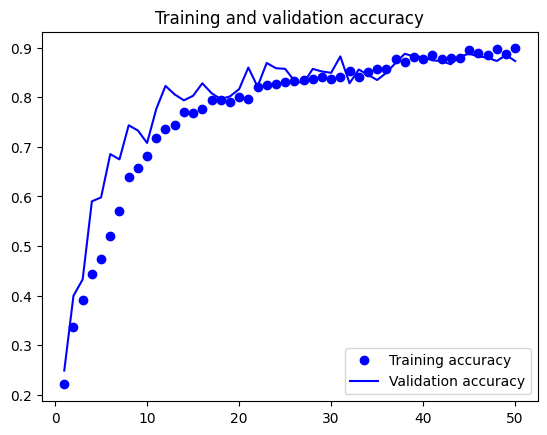

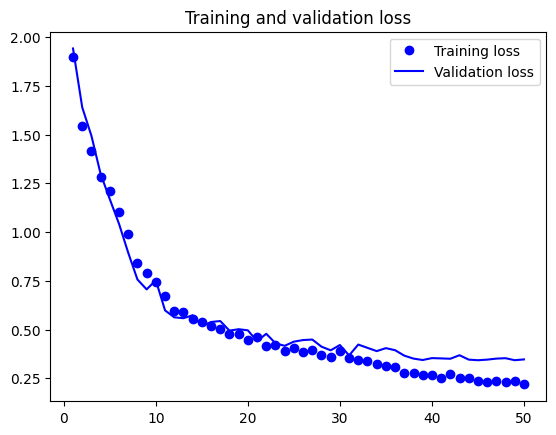

In [24]:
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


We see that the model behaved nicely. The loss and accuracy of the model were aligned throughout, which indicates that our use of data augmentation and dropout have succeeded in avoiding overfitting. Our accuracy converged around 90%. I will now use this model to generate predictions using the 794 unlabeled test records provided by Kaggle.

In [29]:
pred = model.predict(test_generator, steps=test_generator.n, verbose=1)


ValueError: Must provide at least one structure

In [27]:
predicted_class_indices=np.argmax(pred,axis=1)

prediction_labels = [label_map[k] for k in predicted_class_indices]
filenames= test_generator.filenames

NameError: name 'pred' is not defined

I generate a submission file in the required format. I also print a preview of this table in the cell below to show this format.

In [30]:
import csv
csvfile= open('ray_reed_submission.csv', 'w', newline='')
writer= csv.writer(csvfile)

headers= ['file', 'species']

writer.writerow(headers)
t = PrettyTable(headers)
for i, f, p in zip(range(len(filenames)), filenames, prediction_labels):
    writer.writerow([os.path.basename(f),p])
    if i <10:
        t.add_row([os.path.basename(f), p])
    elif i<13:
        t.add_row(['.', '.'])
csvfile.close()
print(t)

NameError: name 'filenames' is not defined

I condider this project to be a success. As mentioned above a major goal of the next project is to establish access to more powerful hardware (multiple nodes with GPU) in order to perform a more systemaic search for hyperparameter tuning. I would also like to explore other computer vision techniques to improve pre-processing efforts and accelerate training process even further. I would also like to better understand why batch normalization and some of the other architectures have yeilded such poor results.